> Asura Enkhbayar - 29.11.2018

# [MKP] - Hypothesis, Annotations, and Engagement

In [618]:
import re

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import datetime
import pandas as pd
from statistics import median, mean

import matplotlib.dates as mdates
import numpy as np
import json

In [623]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

URL_PATTERN = "((http|ftp|https):\/\/[\w\-_]+(\.[\w\-_]+)+([\w\-\.,@?^=%&amp;:/~\+#]*[\w\-\@?^=%&amp;/~\+#])?)"

## The Data

### 1. Making Knowledge Public - Course Material

Data retrieved from course page

In [220]:
classes = pd.read_json("../data/classes.json", orient="records").T
classes.date = classes.date.map(lambda x: x + "T17:30")
classes.date = pd.to_datetime(classes.date, format="%d/%m/%YT%H:%M")
usernames = json.load(open("../data/usernames.json"))

,url,week,part,date,required,speaker,total,resp
id,,,,,,,,
27,http://robinderosa.net/uncategorized/open-for-...,12,3,2018-11-22,True,Robin DeRosa,29,"[{""permissions"": {""read"": [""group:__world__""],..."
36,https://generousthinking.hcommons.org/5-the-un...,12,3,2018-11-22,True,Robin DeRosa,9,"[{""permissions"": {""read"": [""group:__world__""],..."
28,https://generousthinking.hcommons.org/4-workin...,12,3,2018-11-22,True,Robin DeRosa,27,"[{""permissions"": {""read"": [""group:__world__""],..."
34,https://generousthinking.hcommons.org/5-the-un...,12,3,2018-11-22,True,Robin DeRosa,9,"[{""permissions"": {""read"": [""group:__world__""],..."
4,http://www.nytimes.com/2016/11/25/world/europe...,2,0,2018-09-13,False,Jevin West,0,[]
26,https://crln.acrl.org/index.php/crlnews/articl...,11,3,2018-11-15,True,Juan Pablo Alperin,32,"[{""permissions"": {""read"": [""group:__world__""],..."
5,https://paulcairney.wordpress.com/ebpm/,3,1,2018-09-20,True,Nancy Olewiler,24,"[{""permissions"": {""read"": [""group:__world__""],..."
35,https://generousthinking.hcommons.org/5-the-un...,12,3,2018-11-22,True,Robin DeRosa,4,"[{""permissions"": {""read"": [""group:__world__""],..."
14,https://www.scholcommlab.ca/wp-content/uploads...,6,2,2018-10-10,True,John Borrows,108,"[{""permissions"": {""read"": [""group:__world__""],..."


### 2. Survey among students

Survey created with [Google Forms](https://docs.google.com/forms/d/1FplzX_jeCL_nUDDTaLbavBi_f5icdaDKVpgDmHvWD3s/edit?usp=sharing)

In [221]:
survey = pd.read_csv("../data/survey.csv")
eng_survey = survey[['What is your Hypothesis username?', 'eng_part', 'eng_week', 'eng_reading']]
eng_survey.columns = ['user', 'eng_part', 'eng_week', 'eng_reading']
eng_survey = eng_survey.set_index("user")

eng_survey.head()

,eng_part,eng_week,eng_reading
user,,,
anastasiak,1,5,3.0
cypriine,2,12,23.0
carina.albrecht,2,5,20.0
michelle_la,3,12,22.0
CSG,3,10,28.0


## 3. Our Annotations

Data retrieved for the individual readings from the Hypothesis API

In [436]:
comments = pd.read_csv("../data/comments.csv", index_col="id", parse_dates=['created', 'updated'])
comments = comments.merge(readings[['url', 'week', 'part', 'date', 'required', 'speaker']], left_on="url_id", right_index=True)

# Combine the last weeks annotations that were spread across several links
merge_urls = list(range(28, 38))

readings = pd.read_csv("../data/readings.csv", index_col="id", parse_dates=['date'])
readings.sample(10)
resps = []
for i in merge_urls:
    resps.extend(json.loads(readings.loc[i, "resp"]))
readings.loc[28, 'resp'] = json.dumps(resps)
readings.loc[28, 'total'] = len(resps)
readings.drop(merge_urls[1:], inplace=True)

comments.url_id = comments.url_id.map(lambda x: 28 if x in merge_urls else x)
comments['length'] = comments.text.map(lambda x: len(str(x)))
comments['created_day'] = comments.created.map(lambda x: datetime.datetime(year=x.year, month=x.month, day=x.day))
comments['last_minute'] = comments.apply(lambda x: x.created - classes.loc[x.week, 'date'], axis=1)
comments['last_minute'] =  comments['last_minute'].map(lambda x: x.days + x.seconds//86400 if x.days > 0 else x.days - x.seconds//86400)
comments['Has URL'] = comments.text.map(lambda x: re.search(URL_PATTERN, x) is not None if not pd.isna(x) else None)

print("All comments: {}".format(len(comments)))

before_pdc = comments.created<pd.Timestamp(datetime.date(2018, 9, 6))
comments = comments[~before_pdc]

print("Comments before PDC: {}".format(sum(before_pdc)))

our_comments = comments.user.isin(usernames)
comments = comments[our_comments]
print("Our comments: {}".format(sum(our_comments)))

All comments: 1359
Comments before PDC: 22
Our comments: 1218


---

## A (terrible) overview

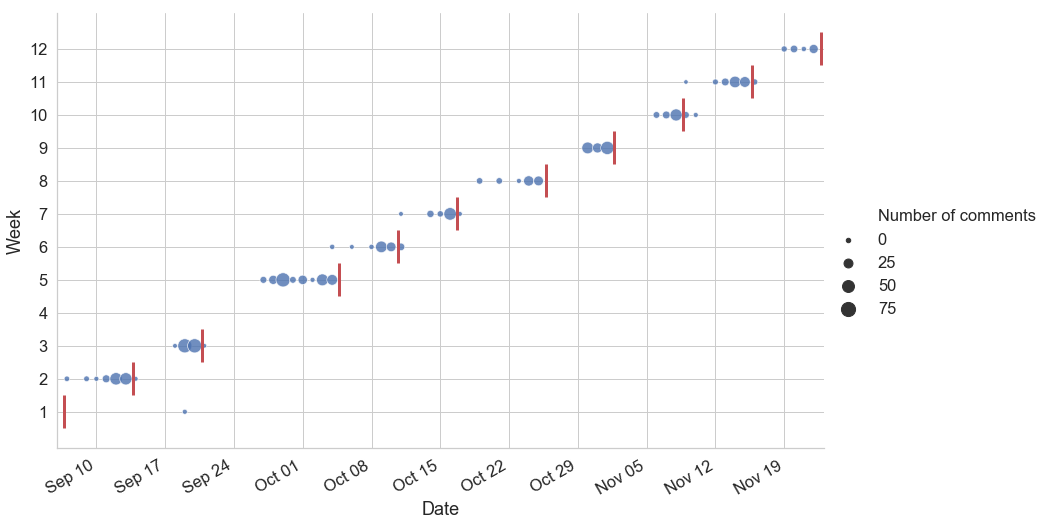

In [624]:
pdf = comments.groupby(["created_day", "week"]).count()['text'].reset_index()
pdf.columns = ['Date', 'Week', 'Number of comments']

g = sns.relplot(x="Date", y="Week", size="Number of comments", alpha=.8,
            sizes=(20,200), palette="muted", data=pdf, height=8, aspect=1.5);
ax = g.facet_axis(0,0)
# ax.legend()
# plt.close(g.fig)

ax.set_xlim((min(pdf.Date)-pd.Timedelta('1 days'), max(pdf.Date)+pd.Timedelta('1 days')));

weekFormatter = mdates.DateFormatter('%b %d');
ax.xaxis.set_major_formatter(weekFormatter);

mondays = mdates.WeekdayLocator(mdates.MONDAY)
ax.xaxis.set_major_locator(mondays)

plt.gcf().autofmt_xdate();

weeks = list(range(1,13))
plt.yticks(weeks)
for w in readings.week.unique():
    date = classes.loc[w, 'date']
    ax.vlines(date, w-.5, w+.5, colors="r", lw=3, alpha=1)
#     plt.text(date+pd.Timedelta("1 days"), w-.7, "Week {}".format(w), fontsize=14, color="r")
    
# ax.yaxis.grid(False)

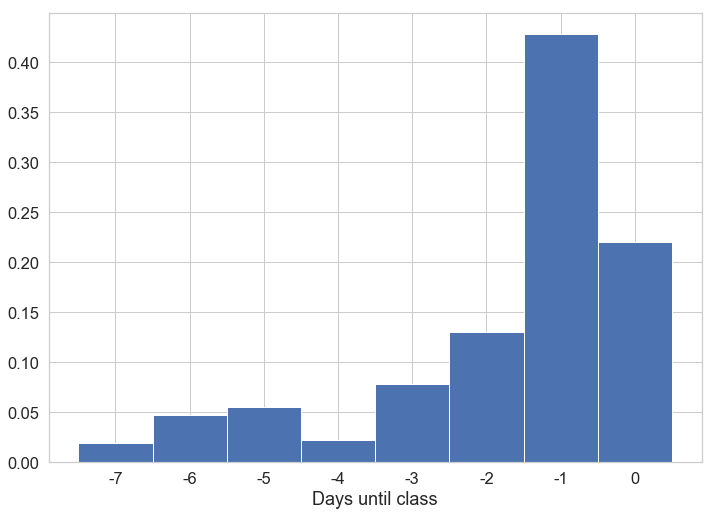

In [625]:
plt.hist(comments.last_minute[comments.last_minute<2], bins=8, normed=True);
plt.xticks([i+.5 for i in range(-7, 1)], list(range(-7, 1)));
plt.xlabel("Days until class");

# Comments per part, week, and readings

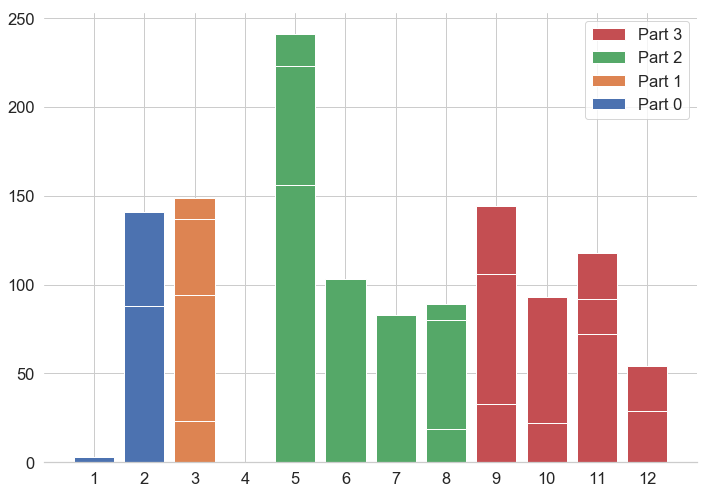

In [785]:
readings_per_week = readings.reset_index().groupby("week")["id"].apply(list)
comments_per_week = comments.groupby("url_id")["url_id"].count()

pdf = pd.DataFrame(columns = ["week", "reading", "comments"])

# f, ax = plt.subplots(figsize=(6, 15))

c = sns.color_palette(n_colors=4)

for w, rs in readings_per_week.items():
    for r in rs:
        rel_readings = readings_per_week.loc[w]
        rel_readings = rel_readings[:rel_readings.index(r)+1]
        pdf.loc[len(pdf)+1] = [w, r, comments_per_week.reindex(rel_readings).sum()]

parts = [0,1,2,3]
for i, row in pdf[::-1].iterrows():
    reading = int(row['reading'])
    week = row['week']
    part = readings.loc[reading].part
    if part in parts:
        label = "Part {}".format(part)
        parts.remove(part)
    else:
        label = None
        
    plt.bar(week, row['comments'], color=c[part], label=label)
    
#     if row['comments'] > 1:
#         if row['comments'] < 20:
#             lh = row['comments'] + 5
#         else:
#             lh = row['comments'] - 15

#         plt.text(week, lh, "{}".format(reading), ha='center', va='bottom')
    
plt.xticks(range(1, 13))
plt.legend()
sns.despine(right=True, top=True, left=True)

## Comments and median lenghts

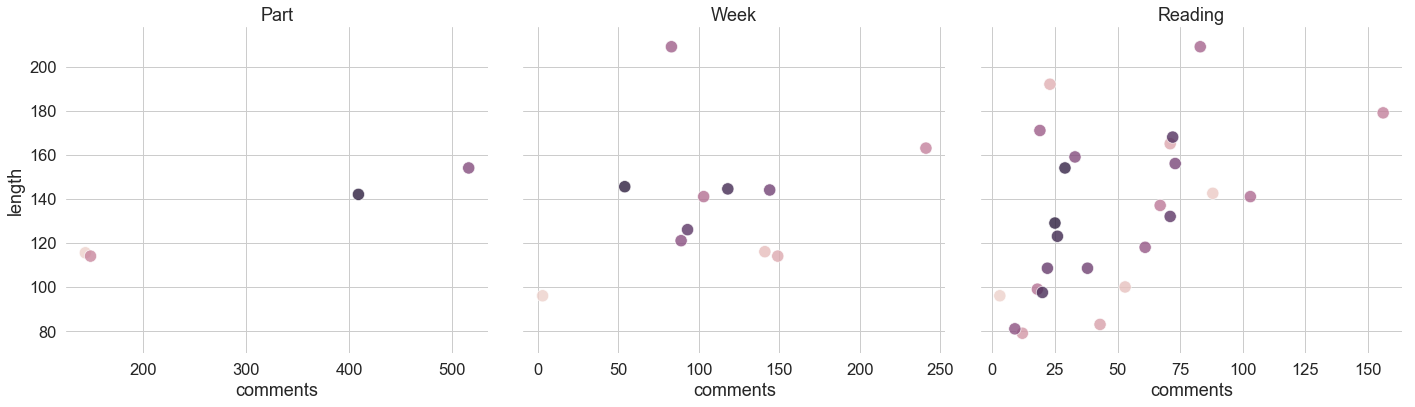

In [956]:
fix, axes = plt.subplots(1,3,figsize=(20,6), sharey=True)
labels = ["Part", "Week", "Reading"]
for ax, by, l in zip(axes, ["part", "week", "url_id"], labels):
    df = pd.DataFrame()
    df['comments'] = comments.groupby(by)["length"].count()
    df['length'] = comments.groupby(by)["length"].median()
    df.reset_index(inplace=True)

    g = sns.relplot(x='comments', y='length', hue=by, data=df, s=150, alpha=.8, ax=ax)
    plt.close(g.fig)
    sns.despine(left=True, bottom=True)
    ax.set_title(l)
plt.tight_layout()

## Parts, weeks, readings per user

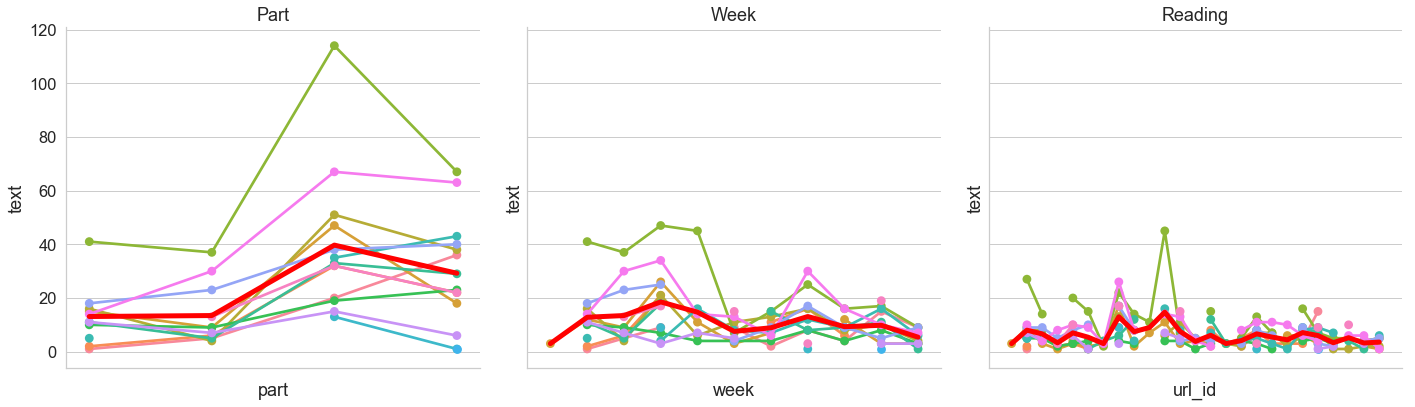

In [959]:
fix, axes = plt.subplots(1,3,figsize=(20,6), sharey=True)
labels = ["Part", "Week", "Reading"]
for ax, by, l in zip(axes, ["part", "week", "url_id"], labels):
    pdf = comments.groupby(["user", by])['text'].count().reset_index()
    sns.pointplot(x=by, y="text", hue="user", data=pdf, ax=ax,  lw=1)
    
    x = pdf.groupby([by]).mean()
    ax.plot(x.text.values, c="red", lw="5", zorder=100)

    ax.legend_.remove()
    ax.set_title(l);
    ax.set_xticklabels([])
    sns.despine(right=True, top=True, ax=ax)
plt.tight_layout()

### Number of comments and the median length

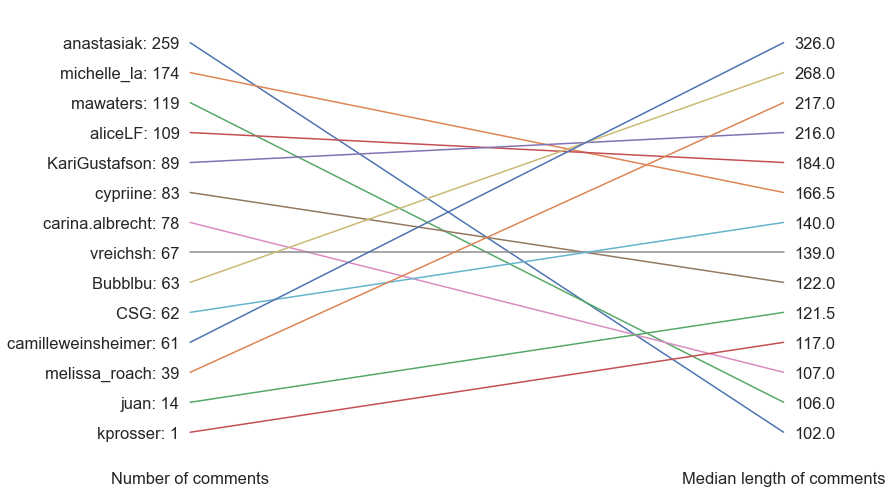

In [824]:
counts = pd.DataFrame(columns=["total", "median"])
counts['total'] = comments.user.value_counts()
counts['median'] = comments.groupby("user")["text"].apply(lambda x: median([len(str(y)) for y in x.tolist()]))
counts.rank(ascending=False).T.plot(legend=False)

ax1 = plt.gca()
ax1.set_ylim((0,15))

ax2 = ax1.twinx()
ax2.set_ylim((0,15))

ax1.set_yticks(range(1, 15))
ax2.set_yticks(range(1, 15))

labels_1 = []
for k, v in counts['total'].items():
    labels_1.append("{}: {}".format(k, v))
ax1.set_yticklabels(labels_1)

labels_2 = []
for k, v in counts['median'].sort_values().items():
    labels_2.append("{}".format(v))
ax2.set_yticklabels(labels_2)

ax1.invert_yaxis()

plt.xticks([0,1], ["Number of comments", "Median length of comments"]);
ax1.grid(False)
ax2.grid(False)
ax1.yaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')
ax1.tick_params(axis='y', pad=-25)
ax2.tick_params(axis='y', pad=-25)

plt.subplots_adjust(hspace=0)
sns.despine(right=True, top=True, bottom=True, left=True, trim=True)

## Number of comments as a measure of engagement

In [961]:
df = pd.DataFrame(columns=['part', 'survey_part', 'week', 'survey_week', 'reading', 'survey_reading'])
by = "text"

x = comments.groupby(["user", "part"])[by].count().reset_index()
df['part'] = x.groupby("user").apply(lambda x: x.loc[x[by].idxmax()])['part']

x = comments.groupby(["user", "week"])[by].count().reset_index()
df['week'] = x.groupby("user").apply(lambda x: x.loc[x[by].idxmax()])['week']

x = comments.groupby(["user", "url_id"])[by].count().reset_index()
df['reading'] = x.groupby("user").apply(lambda x: x.loc[x[by].idxmax()])['url_id']

df['survey_part'] = eng_survey['eng_part']
df['survey_week'] = eng_survey['eng_week']
df['survey_reading'] = eng_survey['eng_reading']
df = df.dropna()
df

,part,survey_part,week,survey_week,reading,survey_reading
user,,,,,,
CSG,2,3.0,5,10.0,11,28.0
aliceLF,2,0.0,5,3.0,11,2.0
anastasiak,2,1.0,5,5.0,14,3.0
camilleweinsheimer,3,2.0,2,8.0,2,27.0
carina.albrecht,2,2.0,5,5.0,12,20.0
cypriine,3,2.0,6,12.0,14,23.0
michelle_la,2,3.0,5,12.0,11,22.0


In [990]:
cols = ["part", "week", "reading"]
matches = pd.DataFrame(columns=cols)
for c in cols:
    for i in df.index.tolist():
        if not pd.isna(df.loc[i, c]) and not pd.isna(df.loc[i, "survey_" + c]):
            survey_max = df.loc[i,"survey_" + c]
            if c=="reading":
                d = "url_id"
            else:
                d = c
            ranks = comments.groupby(["user", d])['text'].count()[i].rank(ascending=False)
            if survey_max in ranks:
                pos = ranks.loc[survey_max]
            else:
                pos = len(ranks)
            matches.loc[i, c] = pos
        else:
            matches.loc[i, c] = None

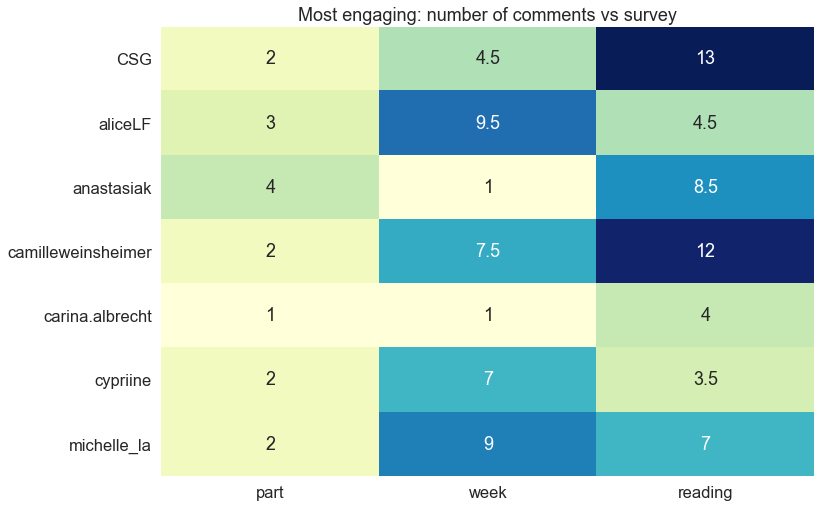

In [991]:
pdf = matches.astype(float).dropna()
sns.heatmap(data=pdf.values, annot=True, cbar=False, cmap="YlGnBu")
plt.xticks([0.5,1.5,2.5], ["part", "week", "reading"]);
plt.yticks([i-.5 for i in range(1, len(pdf)+1)], pdf.index.values, rotation=0);
plt.title("Most engaging: number of comments vs survey");

## Length of comments as engagement

In [984]:
df = pd.DataFrame(columns=['part', 'survey_part', 'week', 'survey_week', 'reading', 'survey_reading'])

by = "length"
x = comments.groupby(["user", "part"])[by].mean().reset_index()
df['part'] = x.groupby("user").apply(lambda x: x.loc[x[by].idxmax()])['part']

x = comments.groupby(["user", "week"])[by].mean().reset_index()
df['week'] = x.groupby("user").apply(lambda x: x.loc[x[by].idxmax()])['week']

x = comments.groupby(["user", "url_id"])[by].mean().reset_index()
df['reading'] = x.groupby("user").apply(lambda x: x.loc[x[by].idxmax()])['url_id']

df['survey_part'] = eng_survey['eng_part']
df['survey_week'] = eng_survey['eng_week']
df['survey_reading'] = eng_survey['eng_reading']
df = df.dropna()
df

,part,survey_part,week,survey_week,reading,survey_reading
user,,,,,,
CSG,0,3.0,2,10.0,2,28.0
aliceLF,0,0.0,2,3.0,20,2.0
anastasiak,2,1.0,5,5.0,12,3.0
camilleweinsheimer,2,2.0,12,8.0,5,27.0
carina.albrecht,3,2.0,9,5.0,20,20.0
cypriine,0,2.0,2,12.0,2,23.0
michelle_la,0,3.0,2,12.0,2,22.0


In [982]:
cols = ["part", "week", "reading"]
matches = pd.DataFrame(columns=cols)
for c in cols:
    for i in df.index.tolist():
        if not pd.isna(df.loc[i, c]) and not pd.isna(df.loc[i, "survey_" + c]):
            survey_max = df.loc[i,"survey_" + c]
            if c=="reading":
                d = "url_id"
            else:
                d = c
            ranks = comments.groupby(["user", d])['length'].mean()[i].rank(ascending=False)
            if survey_max in ranks:
                pos = ranks.loc[survey_max]
            else:
                pos = len(ranks)
            matches.loc[i, c] = pos
        else:
            matches.loc[i, c] = None

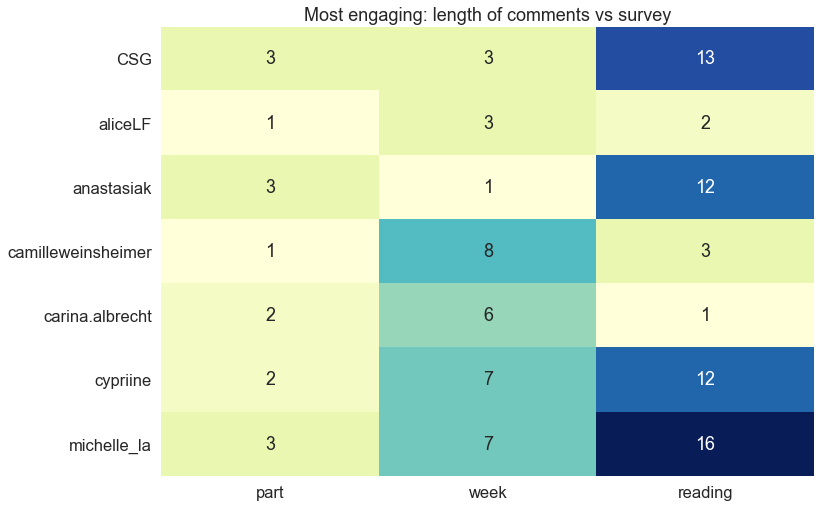

In [989]:
pdf = matches.astype(float).dropna()
sns.heatmap(data=pdf.values, annot=True, cbar=False, cmap="YlGnBu")
plt.xticks([0.5,1.5,2.5], ["part", "week", "reading"]);
plt.yticks([i-.5 for i in range(1, len(pdf)+1)], pdf.index.values, rotation=0);
plt.title("Most engaging: length of comments vs survey");

### Reading Times

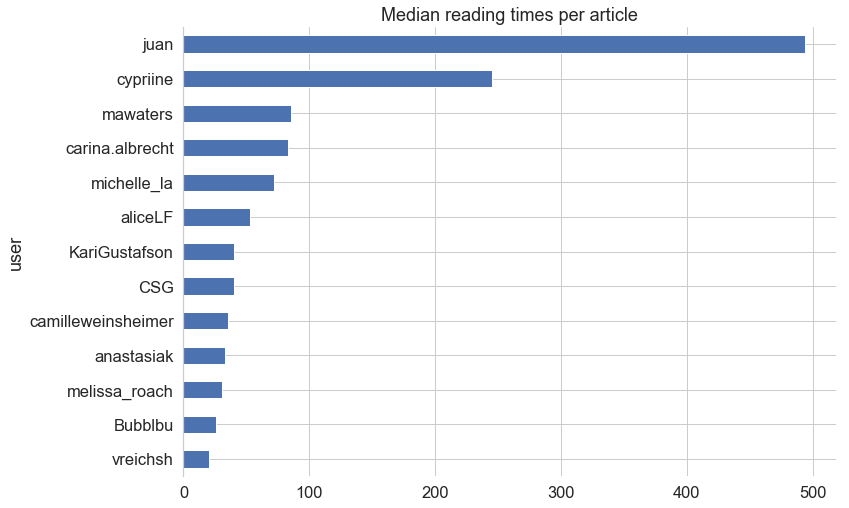

In [806]:
reading_times = pd.DataFrame(columns=["url_id", "week", "part", "user", "mins", "comments"])

for user in usernames:
    for uid in comments.url_id.unique():
        c = comments[(comments.user==user)&(comments.url_id==uid)]
        count = len(c)
        if count > 1:
            reading_time = max(c.created)-min(c.updated)
            reading_time = int(reading_time.seconds // 60)
            reading_times.loc[len(reading_times)+1] = [uid, c.week.iloc[0], c.part.iloc[0], user, reading_time, count]
reading_times.mins = reading_times.mins.astype(int)
reading_times.comments = reading_times.comments.astype(int)
pd.DataFrame(reading_times.groupby("user")['mins'].median()).sort_values(by="mins").plot(kind="barh", legend=False)
plt.title("Median reading times per article")
sns.despine(right=True, top=True, bottom=True)

## Comments with URLs

What about annotations that link to other material?
Is that a particularly engaging activity?

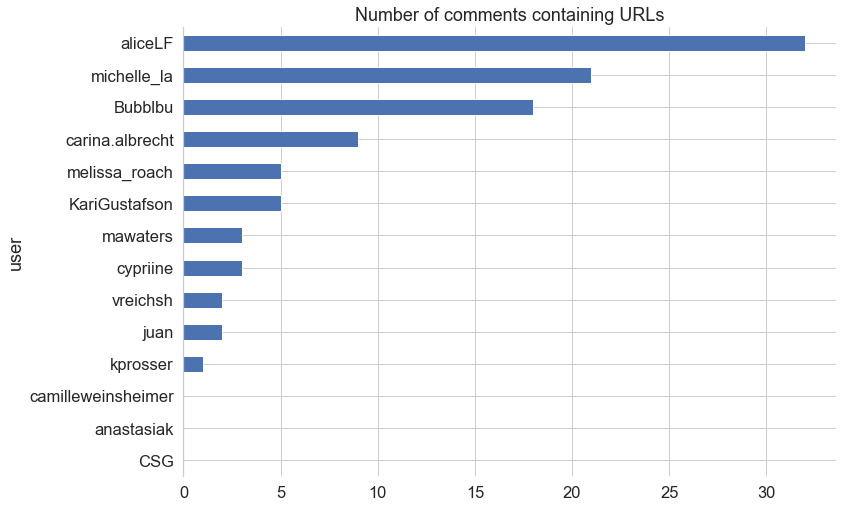

In [805]:
pdf = comments.groupby("user")['Has URL'].apply(lambda x: sum([int(y) if not pd.isna(y) else 0 for y in x]))
pd.DataFrame(pdf).sort_values(by="Has URL").plot(kind="barh", legend=False)
plt.title("Number of comments containing URLs")
sns.despine(right=True, bottom=True, top=True)